In [4]:
import onnxruntime as rt
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

In [5]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

names = ['object']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

In [6]:
session = rt.InferenceSession(
    "../data/models/yolov7/yolov7-tiny.onnx", providers=rt.get_available_providers()
)

In [7]:
session.get_inputs()[0].name, session.get_outputs()[0].name

('images', 'output')

In [22]:
img = cv2.imread("../data/input/train_shelf_images/train1.jpg")
pilimage = Image.open("../data/input/train_shelf_images/train1.jpg")

In [23]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
im.shape

(1, 3, 640, 640)

In [24]:
outname = [i.name for i in session.get_outputs()]
outname

inname = [i.name for i in session.get_inputs()]
inname

inp = {inname[0]:im}

In [25]:
outputs = session.run(outname, inp)[0]
outputs[0]

array([  0.        ,  44.407883  , 382.23026   , 106.23451   ,
       460.87308   ,   0.        ,   0.91727257], dtype=float32)

In [26]:
outputs[1]

array([  0.        , 168.4038    , 284.1864    , 228.54005   ,
       366.364     ,   0.        ,   0.91524696], dtype=float32)

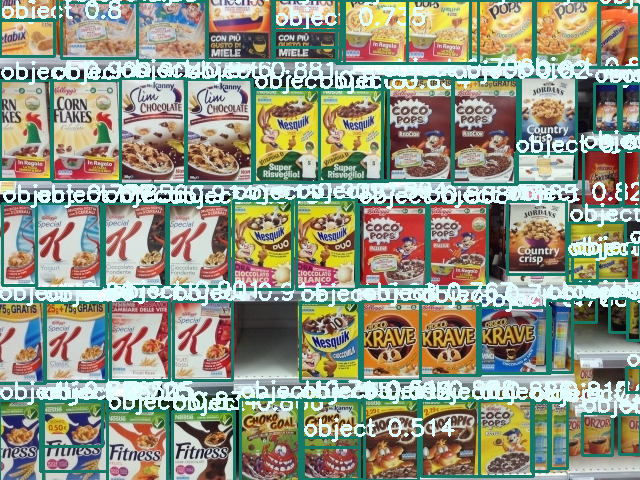

In [28]:
ori_images = [img.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    # cls_id = int(cls_id)
    score = round(float(score),3)
    name = str(cls_id)
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  

Image.fromarray(ori_images[0])

In [15]:
image[

array([[[[238, 238, 238, ..., 215, 217, 220],
         [128,  66, 126, ..., 214, 215, 216],
         [106,  74, 143, ..., 211, 213, 214],
         ...,
         [199, 196, 192, ..., 110, 110, 112],
         [197, 194, 187, ..., 103, 103, 103],
         [194, 193, 182, ..., 103, 102, 101]],

        [[163,  58, 118, ..., 220, 220, 223],
         [122,  58, 111, ..., 219, 218, 219],
         [ 95,  64, 126, ..., 216, 217, 218],
         ...,
         [205, 204, 201, ..., 112, 109, 113],
         [204, 202, 198, ..., 102, 101, 102],
         [203, 203, 194, ..., 101, 100,  99]],

        [[184,  76, 133, ..., 197, 199, 202],
         [144,  77, 125, ..., 196, 197, 198],
         [119,  82, 138, ..., 194, 196, 197],
         ...,
         [200, 204, 209, ..., 121, 121, 124],
         [200, 204, 209, ..., 113, 114, 115],
         [198, 204, 208, ..., 112, 113, 112]]]], dtype=uint8)

In [65]:
cv2.imread(cv.f

In [66]:
results = sess.run(outputs, {inputs: np.expand_dims(image, axis=0)})

TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.